# Different levels of coarse-grained models for zero external load force
We iteratively eliminate states from the kinesin model to simplify the description of
the molecular motor and to obtain a hierarchy of models with
different levels of coarse graining. In each coarse-graining
iteration, the two states that are merged are chosen such that
the transition or the cycle with minimal entropy production
is removed and thus the difference in entropy production
between the models is minimal. In general, there will be
coarse-graining steps that preserve the cycle topology and
steps that change it. For the kinesin model, we can perform
four iterations of the coarse-graining step. In each iteration,
the model loses one state, such that we end up with a two-state network after step 4.


No external stall force is applied and the forward cycle is dominant.

In [2]:
import numpy as np

from matplotlib import pyplot as plt
import math

import time
import random
import networkx as nx
import os

import sys
path='../Bibliotheken/'
sys.path.append(path)

import Steady_State_Calculation_Spanning_Trees as auto
import Kinesin_Parameters as Kinesin
import PDF_Flux_entropy as PDF
#import Analytic_Quantities as analytic
#import Bib3_CountCycles as CountCycles

In [4]:
Force=0  # external load force
i=1      # python starts arrays with 0

In [5]:
def Cycle_Fluxes_Kinesin(w1, G):
    normierung=auto.Normfactor(G)
    #print('forward cycle F')
    zuflussF=(w1[4][5]*w1[3][2]+w1[3][4]*w1[4][5]+w1[4][3]*w1[3][2])
    JF_plus=w1[1][2]*w1[2][5]*w1[5][6]*w1[6][1]*zuflussF/normierung
    JF_minus=w1[1][6]*w1[6][5]*w1[5][2]*w1[2][1]*zuflussF/normierung
    #print([JF_plus, JF_minus])
    #print(zuflussF/normierung)
    #print()

    #print('backward cycle B')
    zuflussB=(w1[1][2]*w1[6][5]+w1[6][1]*w1[1][2]+w1[1][6]*w1[6][5])
    JB_plus=w1[2][3]*w1[3][4]*w1[4][5]*w1[5][2]*zuflussB/normierung
    JB_minus=w1[2][5]*w1[5][4]*w1[4][3]*w1[3][2]*zuflussB/normierung
    #print([JB_plus, JB_minus])
    #print(zuflussB/normierung)
    #print()

    #print('dissipative cycle D')
    zuflussD=1.0
    JD_plus=w1[1][2]*w1[2][3]*w1[3][4]*w1[4][5]*w1[5][6]*w1[6][1]*zuflussD/normierung
    JD_minus=w1[1][6]*w1[6][5]*w1[5][4]*w1[4][3]*w1[3][2]*w1[2][1]*zuflussD/normierung
    #print([JD_plus, JD_minus])
    #print(zuflussD/normierung)
    #print()

    #print('mean and variance for 1200 s')
    #print(JF_plus-JF_minus-JB_plus+JB_minus)
    #print((JF_plus+JF_minus+JB_plus+JB_minus)/12e2)
    return (JF_plus - JF_minus)*zuflussF/normierung, (JB_plus - JB_minus)*zuflussB/normierung, (JD_plus - JD_minus)*zuflussD/normierung
    

def Affinities_Kinesin(w1):
    DeltaS_F=np.log(w1[1][2]*w1[2][5]*w1[5][6]*w1[6][1])-np.log(w1[1][6]*w1[6][5]*w1[5][2]*w1[2][1])
    DeltaS_B=np.log(w1[2][3]*w1[3][4]*w1[4][5]*w1[5][2])-np.log(w1[2][5]*w1[5][4]*w1[4][3]*w1[3][2])
    DeltaS_D=np.log(w1[1][2]*w1[2][3]*w1[3][4]*w1[4][5]*w1[5][6]*w1[6][1])-np.log(w1[1][6]*w1[6][5]*w1[5][4]*w1[4][3]*w1[3][2]*w1[2][1])
    return DeltaS_F, DeltaS_B, DeltaS_D
   
def Chords_Kinesin(w1, p):    
    J12=w1[1][2]*p[1-1]-w1[2][1]*p[2-1]
    J23=w1[2][3]*p[2-1]-w1[3][2]*p[3-1]
    J25=J12-J23
    return J12, J23, J25
def EntropyProductionChords(w1, p):
    J12, J23, J25 = Chords_Kinesin(w1, p)
    dS_F, dS_B, dS_D = Affinities_Kinesin(w1)
    P1 = J12 * dS_F + J23 * dS_B
    P2 = J25 * dS_F + J23 * dS_D
    P3 = J12 * dS_D - J25 * dS_B
    print([P1, P2, P3])
    return P1, P2, P3


def entropyProduction(matrix, p):
    P1=0.
    P2=0.
    N=len(matrix)
    #J=CG.NetFlux(matrix,p)
    for i in range(N):
        for j in range(N):
            P1=P1+(matrix[j][i]*p[j]-matrix[i][j]*p[i])*math.log(p[j]/p[i])
            if matrix[i][j]!=0:
                P2=P2+((matrix[j][i]*p[j]-matrix[i][j]*p[i]))*math.log(matrix[j][i]/matrix[i][j])
    P1=0.5*P1
    P2=0.5*P2
    print('P1=dS/dt= '+str(P1))
    print('P2(copling to set of thermodynamic forces)= '+str(P2))
    return P1+P2

def affinity(matrix, p, state1, state2):
    return np.log(matrix[state1][state2]*p[state1])-np.log(matrix[state2][state1]*p[state2])
    

# 6-state model 
## minimal contribution edge 3->4

In [6]:
[w, w1]=Kinesin.Kinesin(force=Force)

#calculate steady-state
G=auto.Matrix2Graph(w)
p=auto.steady_state(G)
print(p)

P_6state=entropyProduction(matrix=w, p=p)
EntropyProductionChords(w1, p)

print()
print('flux in tri-cyclic 6-state modekl')
flux_6state=w[2-i][5-i]*p[2-i]-w[5-i][2-i]*p[5-i]
print(flux_6state)

[9.81569409e-01 5.89059580e-06 5.95333810e-06 6.54212978e-04
 8.83519759e-03 8.92933633e-03]
P1=dS/dt= -4.558853294867049e-15
P2(copling to set of thermodynamic forces)= 47.610360985157904
[47.610360985157904, 47.61036098515791, 47.61036098515791]

flux in tri-cyclic 6-state modekl
1.765058293576666


# Wcg1

In [7]:
# coarse graining 
# I start counting from 0

i=1
#copying
wcg1=w
#print(w_copy)
#sclicing: delete 3+1 th row (dim=0)
#numpy.delete(arr, obj, axis=None)
wcg1=  np.delete(wcg1, 3, 0)
#print(wcg1)
wcg1=np.delete(wcg1, 3, 1) #delete 3+1 th column (dim=1)
#print(wcg1)
# new rates
wcg1[3-i][2-i]=w[3-i][2-i]*p[3-i]/(p[3-i]+p[4-i])
wcg1[3-i][4-i]=w[4-i][5-i]*p[4-i]/(p[3-i]+p[4-i])
wcg1[4-i][3-i]=w[5-i][4-i]
print()
#print(wcg1)
Gcg1=auto.Matrix2Graph(wcg1)
pcg1=auto.steady_state(Gcg1)
print(pcg1)
print(p)
P_5state=entropyProduction(matrix=wcg1, p=pcg1)
print(P_5state)
print(P_6state-P_5state)

print()
print('flux in tri-cyclic 5-state modekl')
flux_5state=wcg1[2-i][4-i]*pcg1[2-i]-wcg1[4-i][2-i]*pcg1[4-i]
print(flux_5state)



[9.81569409e-01 5.89059580e-06 6.60166316e-04 8.83519759e-03
 8.92933633e-03]
[9.81569409e-01 5.89059580e-06 5.95333810e-06 6.54212978e-04
 8.83519759e-03 8.92933633e-03]
P1=dS/dt= -1.7017637299332478e-15
P2(copling to set of thermodynamic forces)= 47.60504907206324
47.60504907206324
0.005311913094658394

flux in tri-cyclic 5-state modekl
1.765058293576666


# Which edge will be eliminated next?

In [8]:
print('transition affinities')
A12=affinity(matrix=wcg1, p=pcg1, state1=1-i, state2=2-i)
print('A12 ' +str(A12))
A23=affinity(matrix=wcg1, p=pcg1, state1=2-i, state2=3-i)
print('A23 ' +str(A23))
A34=affinity(matrix=wcg1, p=pcg1, state1=3-i, state2=4-i)
print('A34 ' +str(A34))
A45=affinity(matrix=wcg1, p=pcg1, state1=4-i, state2=5-i)
print('A45 ' +str(A45))
A51=affinity(matrix=wcg1, p=pcg1, state1=5-i, state2=1-i)
print('A51 ' +str(A51))
A24=affinity(matrix=wcg1, p=pcg1, state1=2-i, state2=4-i)
print('A24 ' +str(A24))

print()
print('entropy production associated with edge 1->2')
print((wcg1[1-i][2-i]*pcg1[1-i]-wcg1[2-i][1-i]*pcg1[2-i])*A12)
print('entropy production associated with edge 2->3')
print((wcg1[2-i][3-i]*pcg1[2-i]-wcg1[3-i][2-i]*pcg1[3-i])*A23)
print('entropy production associated with edge 3->4')
print((wcg1[3-i][4-i]*pcg1[3-i]-wcg1[4-i][3-i]*pcg1[4-i])*A34)

transition affinities
A12 8.006167338950139
A23 7.695668035526938
A34 21.4568589021754
A45 7.695664372246653
A51 4.510529715796127
A24 6.725512508375683

entropy production associated with edge 1->2
14.140779990814183
entropy production associated with edge 2->3
0.009062290624536323
entropy production associated with edge 3->4
0.02526724000613271


# Merge state 2' and 3' in the 5-state model
## result: unicyclic 4-state model 
# Wcg2

In [9]:
# I start counting from 0
i=1
#copying
wcg2=wcg1
print(wcg2)
#sclicing: delete 3-1 th row (dim=0)
#numpy.delete(arr, obj, axis=None)
wcg2=  np.delete(wcg2, 3-1, 0)
print(wcg2)
wcg2=np.delete(wcg2, 3-1, 1) #delete 3+1 th column (dim=1)
print(wcg2)
# new rates
wcg2[2-i][3-i]=(wcg1[2-i][4-i]*pcg1[2-i]+wcg1[3-i][4-i]*pcg1[3-i])/(pcg1[2-i]+pcg1[3-i])
wcg2[2-i][1-i]=wcg1[2-i][1-i]*pcg1[2-i]/(pcg1[2-i]+pcg1[3-i])
wcg2[3-i][2-i]=wcg1[4-i][2-i]+wcg1[4-i][3-i]
print()
print(wcg2)
Gcg2=auto.Matrix2Graph(wcg2)
pcg2=auto.steady_state(Gcg2)
print(pcg2)
print(pcg1)
P_4state=entropyProduction(matrix=wcg2, p=pcg2)
print(P_4state)
print((P_5state-P_4state)/P_5state)

print()
print('flux in unicyclic 4-state modekl')
flux_4state=wcg2[2-i][3-i]*pcg2[2-i]-wcg2[3-i][2-i]*pcg2[3-i]
print(flux_4state)

[[0.00000000e+00 1.80000000e+00 0.00000000e+00 0.00000000e+00
  2.00000000e-02]
 [1.00000000e+02 0.00000000e+00 2.00000000e+02 3.00000000e+05
  0.00000000e+00]
 [0.00000000e+00 8.11614309e-04 0.00000000e+00 1.78376771e+00
  0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 6.40000000e-11 0.00000000e+00
  2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 0.00000000e+00 9.00000000e-02
  0.00000000e+00]]
[[0.0e+00 1.8e+00 0.0e+00 0.0e+00 2.0e-02]
 [1.0e+02 0.0e+00 2.0e+02 3.0e+05 0.0e+00]
 [0.0e+00 2.4e-01 6.4e-11 0.0e+00 2.0e+02]
 [2.0e+02 0.0e+00 0.0e+00 9.0e-02 0.0e+00]]
[[0.0e+00 1.8e+00 0.0e+00 2.0e-02]
 [1.0e+02 0.0e+00 3.0e+05 0.0e+00]
 [0.0e+00 2.4e-01 0.0e+00 2.0e+02]
 [2.0e+02 0.0e+00 9.0e-02 0.0e+00]]

[[0.00000000e+00 1.80000000e+00 0.00000000e+00 2.00000000e-02]
 [8.84398269e-01 0.00000000e+00 2.65496280e+03 0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 0.00000000e+00 2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 9.00000000e-02 0.00000000e+00]]
[9.81569409e-01 6.66056912e-04 

# Alternative Wcg2b
## Merge state 1' and 2' in the 5-state model
### yields bigger difference in entropy production than merging 2' and 3'

In [10]:
# I start counting from 0
i=1
#copying
wcg2b=wcg1
print(wcg2b)
#sclicing: delete 2-1 th row (dim=0)
#numpy.delete(arr, obj, axis=None)
wcg2b=  np.delete(wcg2b, 2-1, 0)
print(wcg2b)
wcg2b=np.delete(wcg2b, 2-1, 1) #delete 3+1 th column (dim=1)
print(wcg2b)
# new rates
wcg2b[1-i][4-i]=(wcg1[1-i][5-i]*pcg1[1-i])/(pcg1[1-i]+pcg1[2-i])
wcg2b[1-i][3-i]=wcg1[2-i][4-i]*pcg1[2-i]/(pcg1[1-i]+pcg1[2-i])
wcg2b[3-i][1-i]=wcg1[4-i][2-i]
wcg2b[1-i][2-i]=wcg1[2-i][3-i]*pcg1[2-i]/(pcg1[1-i]+pcg1[2-i])
wcg2b[2-i][1-i]=wcg1[3-i][2-i]

print()
print(wcg2b)
Gcg2b=auto.Matrix2Graph(wcg2b)
pcg2b=auto.steady_state(Gcg2b)
print(pcg2b)
print(pcg1)
P_4stateb=entropyProduction(matrix=wcg2b, p=pcg2b)
print(P_4stateb)
print((P_5state-P_4stateb)/P_5state)

[[0.00000000e+00 1.80000000e+00 0.00000000e+00 0.00000000e+00
  2.00000000e-02]
 [1.00000000e+02 0.00000000e+00 2.00000000e+02 3.00000000e+05
  0.00000000e+00]
 [0.00000000e+00 8.11614309e-04 0.00000000e+00 1.78376771e+00
  0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 6.40000000e-11 0.00000000e+00
  2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 0.00000000e+00 9.00000000e-02
  0.00000000e+00]]
[[0.00000000e+00 1.80000000e+00 0.00000000e+00 0.00000000e+00
  2.00000000e-02]
 [0.00000000e+00 8.11614309e-04 0.00000000e+00 1.78376771e+00
  0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 6.40000000e-11 0.00000000e+00
  2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 0.00000000e+00 9.00000000e-02
  0.00000000e+00]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.00000000e-02]
 [0.00000000e+00 0.00000000e+00 1.78376771e+00 0.00000000e+00]
 [0.00000000e+00 6.40000000e-11 0.00000000e+00 2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 9.00000000e-02 0.00000000e+00]]

[[0.00000000e+00 1.20023

# Affinities in unicyclic 4-state model (wcg2)

In [11]:
print('transition affinities in unicyclic 4-state model')
A12=affinity(matrix=wcg2, p=pcg2, state1=1-i, state2=2-i)
print('A12 ' +str(A12))
A23=affinity(matrix=wcg2, p=pcg2, state1=2-i, state2=3-i)
print('A23 ' +str(A23))
A34=affinity(matrix=wcg2, p=pcg2, state1=3-i, state2=4-i)
print('A34 ' +str(A34))
A41=affinity(matrix=wcg2, p=pcg2, state1=4-i, state2=1-i)
print('A41 ' +str(A41))

transition affinities in unicyclic 4-state model
A12 8.006167338950139
A23 6.726178649659067
A34 7.695664372246653
A41 4.510529715796126


# in unicylic 4-state model edege 4->1 will be eliminated
## wcg3

In [12]:
# I start counting from 0
i=1
#copying
wcg3=wcg2
print(wcg3)
#sclicing: delete 4-1 th row (dim=0)
#numpy.delete(arr, obj, axis=None)
wcg3=  np.delete(wcg3, 4-1, 0)
print(wcg3)
wcg3=np.delete(wcg3, 4-1, 1) #delete 4-1 th column (dim=1)
print(wcg3)
# new rates
wcg3[1-i][2-i]=(wcg2[1-i][2-i]*pcg2[1-i])/(pcg2[1-i]+pcg2[4-i])
wcg3[1-i][3-i]=(wcg2[4-i][3-i]*pcg2[4-i])/(pcg2[1-i]+pcg2[4-i])
wcg3[3-i][1-i]=wcg2[3-i][4-i]

print()
print(wcg3)
Gcg3=auto.Matrix2Graph(wcg3)
pcg3=auto.steady_state(Gcg3)
print(pcg3)
print(pcg2)
P_3state=entropyProduction(matrix=wcg3, p=pcg3)
print(P_3state)
print((P_4state-P_3state)/P_4state)

print()
print('flux in unicyclic 3-state modekl')
flux_3state=wcg3[2-i][3-i]*pcg3[2-i]-wcg3[3-i][2-i]*pcg3[3-i]
print(flux_3state)

[[0.00000000e+00 1.80000000e+00 0.00000000e+00 2.00000000e-02]
 [8.84398269e-01 0.00000000e+00 2.65496280e+03 0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 0.00000000e+00 2.00000000e+02]
 [2.00000000e+02 0.00000000e+00 9.00000000e-02 0.00000000e+00]]
[[0.00000000e+00 1.80000000e+00 0.00000000e+00 2.00000000e-02]
 [8.84398269e-01 0.00000000e+00 2.65496280e+03 0.00000000e+00]
 [0.00000000e+00 2.40000000e-01 0.00000000e+00 2.00000000e+02]]
[[0.00000000e+00 1.80000000e+00 0.00000000e+00]
 [8.84398269e-01 0.00000000e+00 2.65496280e+03]
 [0.00000000e+00 2.40000000e-01 0.00000000e+00]]

[[0.00000000e+00 1.78377302e+00 8.11349104e-04]
 [8.84398269e-01 0.00000000e+00 2.65496280e+03]
 [2.00000000e+02 2.40000000e-01 0.00000000e+00]]
[9.90498746e-01 6.66056912e-04 8.83519759e-03]
[9.81569409e-01 6.66056912e-04 8.83519759e-03 8.92933633e-03]
P1=dS/dt= -1.3322676295501878e-15
P2(copling to set of thermodynamic forces)= 39.613156547656175
39.613156547656175
0.1674377936948953

flux in unicyclic 3-s

# Make 2-state model 
## wcg4

In [14]:
wcg4=np.zeros((2,2))
wcg4[2-i][1-i]=(wcg3[2-i][1-i]*pcg3[2-i]+wcg3[3-i][1-i]*pcg3[3-i])/(pcg3[2-i]+pcg3[3-i])
wcg4[1-i][2-i]=wcg3[1-i][2-i]+wcg3[1-i][3-i]
pcg4=[wcg4[2-i][1-i]/(wcg4[2-i][1-i]+wcg4[1-i][2-i]), wcg4[1-i][2-i]/(wcg4[2-i][1-i]+wcg4[1-i][2-i])]
print(pcg4)
print(pcg3)

print()
print('flux in equilibrium 2-state modekl')
flux_2state=wcg4[1-i][2-i]*pcg4[1-i]-wcg4[2-i][1-i]*pcg4[2-i]
print(flux_2state)

[0.9904987455018437, 0.00950125449815637]
[9.90498746e-01 6.66056912e-04 8.83519759e-03]

flux in equilibrium 2-state modekl
2.220446049250313e-16


In [15]:
print('fluxes')
print([flux_6state,flux_5state,flux_4state,flux_3state, flux_2state])

fluxes
[1.765058293576666, 1.765058293576666, 1.7662358769369022, 1.7662358769369024, 2.220446049250313e-16]


In [16]:
CG_nodes=[0,1/6,2/6,3/6,4/6]
CG_Entropy=[0, (P_6state-P_5state)/P_6state, (P_6state-P_4state)/P_6state, (P_6state-P_3state)/P_6state, (P_6state-0)/P_6state]
diff=np.array(CG_Entropy)-np.array(CG_nodes)
print(diff)
CG_fluxes=[flux_6state-flux_6state,(flux_5state-flux_6state)/flux_6state,(flux_4state-flux_6state)/flux_6state,(flux_3state-flux_6state)/flux_6state, (flux_6state-flux_2state)/flux_6state]
print(CG_fluxes)

[ 0.         -0.1665551  -0.33269177 -0.33202807  0.33333333]
[0.0, 0.0, 0.0006671640050198444, 0.0006671640050199702, 0.9999999999999999]


(0.0, 0.67)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


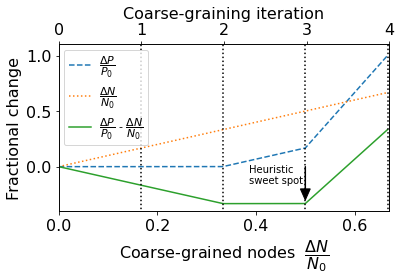

In [17]:
f_size = 16
legend_size = 11

fig, axs = plt.subplots(1,1)
axs.set_ylabel('Fractional change', fontsize=f_size)
axs.set_xlabel('Coarse-grained nodes  $\dfrac{\Delta N}{N_0}$', fontsize=f_size)
#fig.suptitle('Zero external load force')
    
axs.plot(CG_nodes, CG_Entropy, label='$\dfrac{\Delta P}{P_0}$', linestyle='--')
axs.plot(CG_nodes, CG_nodes, label='$\dfrac{\Delta N}{N_0}$', linestyle='dotted')
axs.plot(CG_nodes, diff, label='$\dfrac{\Delta P}{P_0}$ - $\dfrac{\Delta N}{N_0}$')

axs.arrow( x=0.5, y=-0., dx=0, dy=-0.2,  head_width=0.02, head_length=0.1, fc='k', ec='k')  
axs.legend(prop={'size': legend_size}, loc='upper left')
    
#plot iteration
itera1=[[1/6,1/6], [-0.6, 1.1]]
itera2=[[2/6,2/6], [-0.6, 1.1]]
itera3=[[3/6,3/6], [-0.6, 1.1]]
itera4=[[4/6,4/6], [-0.6, 1.1]]
axs.plot(itera1[0], itera1[1], linestyle=':', color='black')
axs.plot(itera2[0], itera2[1], linestyle=':', color='black')
axs.plot(itera3[0], itera3[1], linestyle=':', color='black')
axs.plot(itera4[0], itera4[1], linestyle=':', color='black')
axs.set_ylim([-0.4,1.1])
axs.set_xlim([-0,0.67])
axs.tick_params(axis='both', labelsize=f_size)
    
ax2 = axs.twiny()
ax2.tick_params(axis='both', labelsize=f_size)
print(axs.get_xlim())
new_tick_locations = np.array([0,1,2,3,4])
ax2.set_xticks(new_tick_locations)
#ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Coarse-graining iteration", fontsize=f_size)
plt.text(2.3, -0.15, 'Heuristic \nsweet spot')

fig.tight_layout()
fig.savefig('Iteratives_CG_Kinesin_Force=0.eps',bbox_inches="tight")
plt.show()

(0.0, 0.67)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


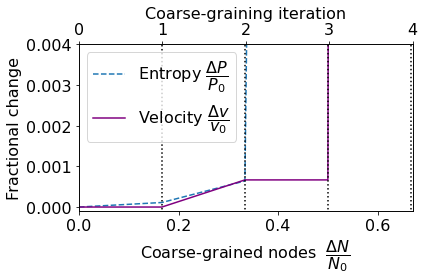

In [18]:
fig, axs = plt.subplots(1,1)
axs.set_ylabel('Fractional change', fontsize=f_size)
axs.set_xlabel('Coarse-grained nodes  $\dfrac{\Delta N}{N_0}$', fontsize=f_size)
#fig.suptitle('Zero external load force')

axs.plot(CG_nodes, CG_Entropy, label='Entropy $\dfrac{\Delta P}{P_0}$', linestyle='--')
axs.plot(CG_nodes, CG_fluxes, label='Velocity $\dfrac{\Delta v}{v_0}$', color='purple')

axs.legend(prop={'size': f_size}, loc='upper left')

#plot iteration
itera1=[[1/6,1/6], [-0.6, 1.1]]
itera2=[[2/6,2/6], [-0.6, 1.1]]
itera3=[[3/6,3/6], [-0.6, 1.1]]
itera4=[[4/6,4/6], [-0.6, 1.1]]
axs.plot(itera1[0], itera1[1], linestyle=':', color='black')
axs.plot(itera2[0], itera2[1], linestyle=':', color='black')
axs.plot(itera3[0], itera3[1], linestyle=':', color='black')
axs.plot(itera4[0], itera4[1], linestyle=':', color='black')
axs.set_ylim([-0.0001,0.004])
#axs.set_ylim([-0.001,0.25])
axs.set_xlim([-0,0.67])
#axs.ticklabel_format(axis='y',style='sci', scilimits=(0,2) )
axs.tick_params(axis='both', labelsize=f_size)

import matplotlib.ticker as mtick
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

ax2 = axs.twiny()
ax2.tick_params(axis='x', labelsize=f_size)
print(axs.get_xlim())
new_tick_locations = np.array([0,1,2,3,4])
ax2.set_xticks(new_tick_locations)
#ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Coarse-graining iteration", fontsize=f_size)
#plt.text(2.3, -0.25, 'Heuristic \nsweet spot')

#axs.arrow( x=2/6, y=0.002, dx=0, dy=0.0004,  head_width=0.01, head_length=0.0001, fc='k', ec='k')
#plt.text(1.12, 0.002, 'uni-cyclic\nmodel ',fontsize=14)

fig.tight_layout()
fig.savefig('Iteratives_CG_Kinesin_Force=0_velocity.eps',bbox_inches="tight")
plt.show()